**Autoencoders and GANs**

This notebook is inspired by https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
#This segment verifies the setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"



# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

IS_COLAB=0
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 6ms/sample - loss: 0.3039
Epoch 2/20
60/60 [==============================] - 0s 69us/sample - loss: 0.2834
Epoch 3/20
60/60 [==============================] - 0s 75us/sample - loss: 0.2667
Epoch 4/20
60/60 [==============================] - 0s 64us/sample - loss: 0.2513
Epoch 5/20
60/60 [==============================] - 0s 74us/sample - loss: 0.2373
Epoch 6/20
60/60 [==============================] - 0s 72us/sample - loss: 0.2232
Epoch 7/20
60/60 [==============================] - 0s 74us/sample - loss: 0.2101
Epoch 8/20
60/60 [==============================] - 0s 67us/sample - loss: 0.1986
Epoch 9/20
60/60 [==============================] - 0s 75us/sample - loss: 0.1839
Epoch 10/20
60/60 [==============================] - 0s 75us/sample - loss: 0.1719
Epoch 11/20
60/60 [==============================] - 0s 73us/sample - loss: 0.1603
Epoch 12/20
60/60 [==============================] - 0s 71us/sample - loss: 0

In [5]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


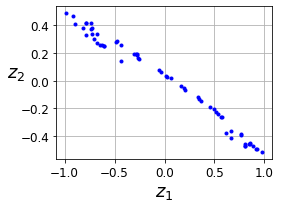

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 8s 150us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 8s 142us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3048 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 9s 157us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3033 - val_rounded_accuracy: 0.9120
Epoch 4/20
55000/55000 [==============================] - 8s 148us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9277
Epoch 5/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2924 - rounded_accuracy: 0.9268 - val_loss: 0.2923 - val_rounded_accuracy: 0.9280
Epoch 6/20
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2908 - rounded_accuracy: 0.9280 - val

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [10]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


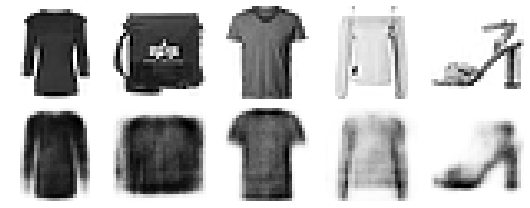

In [13]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")